In [435]:
import numpy as np
import pandas as pd
import chardet
from datetime import date
from scipy.stats import norm
from scipy.stats import chi2
import matplotlib.pyplot as plt

## 1. Чтение, обработка данных

In [436]:
def compute_and_add_days(df, name):
    df = df.reset_index(drop = True)
    n_cols = df.shape[1]
    n_rows = df.shape[0]
    ret = df;
    uncorrects = [[] , 0];
    row_days = []
    row0 = df.loc[0];
    start = date(row0[0], row0[1], row0[2])
    
    for i in range(0, n_rows):   
        row = ret.loc[i]
        if ((row[2] < 1) or (row[2] > 31)): #or (row[1] < 1) or (row[1] > 12)):
            ret = ret.drop(i, axis = 0)
            continue 
            
        curr = date(row[0], row[1], row[2])
        row_days.append((curr - start).days)
        
    ret[name] = row_days
    ret = ret.reset_index(drop = True)
    ret = ret.sort_values(by=[name])
    ret = ret.reset_index(drop=True)
    return ret

## 2. Разбиение данных на две выборки по времени и по колличеству заявок в промежутках времени

In [666]:
def first_method_reduce(df, step):
    n_cols = df.shape[1]
    n_rows = df.shape[0]
    
    ret = []
    i = 0
    while (i < (n_rows - 1)):
        row = [df.loc[i][n_cols - 1], i]
        while ((df.loc[i + 1][n_cols - 1] - df.loc[i][n_cols - 1] <= step) and (i < (n_rows - 2))):
            i += 1            
        i += 1
        ret.append([row[0], i - row[1]])
    ret[-1][1] += 1
    ret = np.array(ret)
    return (ret)

def second_method_reduce(df, step):
    n_cols = df.shape[1]
    n_rows = df.shape[0]
    
    ret = []
    i = 0
    while (i < (n_rows - 1)):
        row = [df.loc[i][n_cols - 1], i]
        while ((df.loc[i + 1][n_cols - 1] - row[0] < step) and (i < (n_rows - 2))):
            i += 1            
        i += 1
        ret.append([row[0], i - row[1]])
    ret[-1][1] += 1
    ret = np.array(ret)
    return (ret)

def make_reduce(sample, method, step, country):
    reduce = method(sample, step)
    print("Reduce data for", country, "with days from start, shape: " , len(reduce))
    time_smp = np.diff(reduce[:,0])
    requests_smp = reduce[:, 1]
    print("time intervals = ")
    print(time_smp)
    print("requests = ")
    print(requests_smp)
    return time_smp, requests_smp

## 3. Проверка независимости случайных величин в выборках с помощью критерия Валлиса - Мура

In [916]:
def num_sign_changes(arr):
    i = 0
    sign = arr[0]
    count = 0
    while i < len(arr) - 1:
        if arr[i] != 0:
            if sign == 0:
                sign = arr[i]
            elif sign != arr[i]:
                count += 1
                sign = arr[i]
        i +=1
    return count

def Wallis_Murr_number(sample):
    sample_diff = np.diff(sample)
    gamma = num_sign_changes(np.sign(sample_diff)) - 2
    n = len(sample)
    return np.abs((gamma - (2*n - 7)/3)*np.sqrt(90/ (16*n - 29))) 

def Wallis_Murr_crit(sample, alfa, str):
    Z1 = Wallis_Murr_number(sample)
    f = norm(0, 1)
    treshold_val = f.ppf(alfa/2)
    if (Z1 <= -treshold_val):
        print(str, "is undependet", round(Z1, 2), " <= ", -round(treshold_val,2))
    else:
        print(str, "is dependet", round(Z1, 2), " > ", -round(treshold_val, 2))
        

## 4. Оценка параметров распределения для выборки событий и критерий хи2

In [937]:
def func_sum(inter, func):
    sum = 0 
    for i in np.arange(inter[0], inter[1] + 1): 
        sum += func(i)
    return sum

def divide_time(time, r, func):
    tmp = np.bincount(time)
    interv = len(time)//r
    intervp = 1/r
    m = np.zeros(r)
    p = np.zeros(r)
    j = 0
    for i in range(0, r):
        if (j < len(tmp)):
            m[i] += tmp[j]
            p[i] += func(j)
            j += 1
        while (p[i] < intervp) and (j < len(tmp)):
            intervp = (1-sum(p))/(r - i)
            m[i] += tmp[j]
            p[i] += func(j)
            j += 1
    p[len(p) - 1] = 1 - sum(p[0:len(p) - 1])
    return m, p

def Chi_squre_number(m, p):
    ret = 0
    r = len(m)
    n = np.sum(m)
    for i in range(0, r):
        ret += (m[i] - n*p[i])**2 / n*p[i]
    return ret

def Chi_2_crit(sample, r, P, alfa, num_param):
    m, p = divide_time(sample, r, P)    
    chi_stat = Chi_squre_number(m, p)
    chi_2 = chi2(r - 1 - num_param)
    print("Chi2 degree: ", r - 1 - num_param)
    chi_2_tres1 = chi_2.ppf(1 - alfa)
    print("Chi2 statistic:         ", round(chi_stat, 2))
    print("Chi2 treshold val right:", round(chi_2_tres1, 2))

In [984]:
def plot_hist(sample, r_bound, P, ax, title, n=0):
    x = np.arange(0, r_bound)
    Fx = []
    
    for i in x:
        Fx.append(P(i))
    if (n == 0):
        n = round(np.math.sqrt(len(sample)))

    bins = np.linspace(sample.min(), r_bound, n) 
    ax.hist(sample, bins, density=1)
    ax.plot(x, Fx, color="red")
    ax.legend([r'$f_\xi(x)$', r'$histogram$'], fontsize=20)
    ax.set_title("Hist Plot " + title , fontsize = 15)
    ax.grid()

## 5. Оценка параметров распределения для выборки времени происшествия события относительно предыдущего события и критерий хи2

In [643]:
data = pd.read_csv('C:/Users/User/Desktop/Study/Scientific_work/globalterrorismdb_0718dist.csv', encoding='ISO-8859-1', low_memory=False)
print("Input data shape: " , data.shape)
data = data.drop(data.iloc[:, 9:],  axis=1)
data = data.drop(data.columns[[0, 4, 5, 6]], axis = 1)

Input data shape:  (181691, 135)


In [644]:
df_russia = data[ (data["country_txt"] == "Russia") | (data["country_txt"] == "Soviet Union")  ] 
print("Data for Russia shape: " , df_russia.shape)
data.head()
df_russia.head()

Data for Russia shape:  (2272, 5)


,iyear,imonth,iday,country,country_txt
5768,1978,1,8,359,Soviet Union
38018,1989,4,20,359,Soviet Union
38019,1989,4,20,359,Soviet Union
39006,1989,7,26,359,Soviet Union
39007,1989,7,26,359,Soviet Union


In [645]:
df_size = df_russia.shape[0];
df_russia = compute_and_add_days(df_russia, "days from start")
print("Preprocess data for Russia, with days from start, shape: " , df_russia.shape)

Preprocess data for Russia, with days from start, shape:  (2267, 6)


In [908]:
step = 10;
time_proc = (df_russia.iloc[:,5:].values).reshape(2267)
time_proc = np.diff(time_proc)
print(time_proc)
time_arr, requests = make_reduce(df_russia, first_method_reduce, step, "Russia")

[4120    0   97 ...   32    6    1]
Reduce data for Russia with days from start, shape:  240
time intervals = 
[4120   97   30   22   18   92   45   34   19   16   28   14   33   17
   64  110   25   21   12   39   25   24   25   12   23   61   31   54
   11   20   37   13   73   21   70   19   14  451   40   25   22   40
   47   19   60   20   13   67   13   55   28   35   35   24   34   39
   24   36   48   79   17   12   24   29   34   59   18   35   44   25
   46   45   12   35   20   64   43   40   31   35   44   45   18   12
   40   31   44   11   39   26   55   19   31   50   21   28   80   49
   15   36   20   40   14   35   35   26   35  160   27   57   38   29
   13   57   14   97   45   90   13   16   76   30   45   25   77   60
   21   30   15   49   75   12   17   38   14   75   13   12   68   20
   41   43   46   25   40   13   33   35   16   54   31  125   75   26
   23   46   46   19   23   34   56   15   38   80   60   12   46   29
   15   28   34   35   77   14   26  

In [923]:
alfa = 0.05
print("Wallis-Mur criterion")
Wallis_Murr_crit(time_proc, alfa, "Time initial for Russia")
Wallis_Murr_crit(time_arr, alfa, "Time diffs for Russia")
Wallis_Murr_crit(requests, alfa, "Requests for Russia")    

Wallis-Mur criterion
Time initial for Russia is dependet 5.7  >  1.96
Time diffs for Russia is undependet 1.08  <=  1.96
Requests for Russia is undependet 1.33  <=  1.96


In [802]:
def Poisson_param(param):
    def Poisson(k):
        fact = 1
        if k < 1:
            return 0
        else:
            for i in range(1, k):
                fact *= param/i
            return np.exp(-param) * fact
    return Poisson

def geom_param(param):
    def geom(k):
        if k < 1:
            return 0
        else:
            return np.power((1-param), k-1) * param
    return geom

def mix_distrib_param(p, func_1, func_2):
    def mix_distrib(k):
        return p*func_1(k) + (1-p)*func_2(k)
    return mix_distrib

from scipy.optimize import fsolve

def GMM_Poisson(sample):
    a1 = np.average(sample)
    return a1 - 1

def GMM_geom(sample):
    a1 = np.average(sample)
    return 1/a1

def GMM_mix_distrib(sample, a2, a3):
    a1 = np.average(sample)
    equations = lambda x: (x*a2 + (1 - x)*a3 - a1)
    return fsolve(equations, 0.9)

def process_sample(sample, delimiter, missed_vals):
    sample1 = (np.sort(sample))[0:len(sample) - missed_vals]
    ret1 = sample1[sample1 <= delimiter]
    ret2 = sample1[sample1 > delimiter]
    return ret1, ret2

parameters p, a1, a2 =  [ 0.915  3.872 57.417]
Chi2 degree:  11
Chi2 statistic:          4.79
Chi2 treshold val right: 19.68


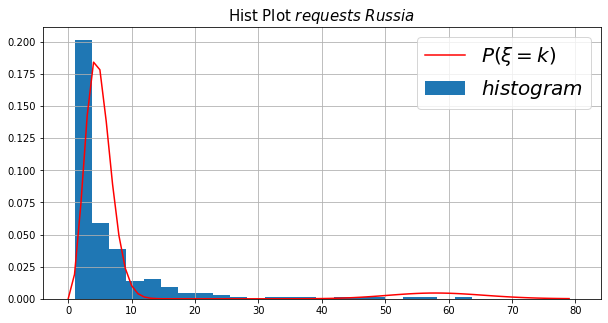

In [956]:
delimiter = 30
missed_vals = 2

sample1, sample2 = process_sample(requests, delimiter, missed_vals)
a1 = np.average(sample1)
a2 = np.average(sample2)
param1 = GMM_Poisson(sample1)

param2 = GMM_Poisson(sample2)

P1 = Poisson_param(param1)
P2 = Poisson_param(param2)
param3 = GMM_mix_distrib(requests, a1, a2)
print("parameters p, a1, a2 = ", np.around([param3[0], param1, param2], 3))
Mixed = mix_distrib_param(param3, P1, P2)

nrow = 1
fig, (ax1) = plt.subplots(nrows=nrow, figsize=(10,5*nrow))
plot_hist(requests, 80, Mixed, ax1, "$requests$ $Russia$", 30)

alfa = 0.05
r = 15
Chi_2_crit(requests, r, Mixed, alfa, 3)

parameters p, a1, a2 =  [ 0.915  0.205 57.417]
Chi2 degree:  11
Chi2 statistic:          0.54
Chi2 treshold val right: 19.68


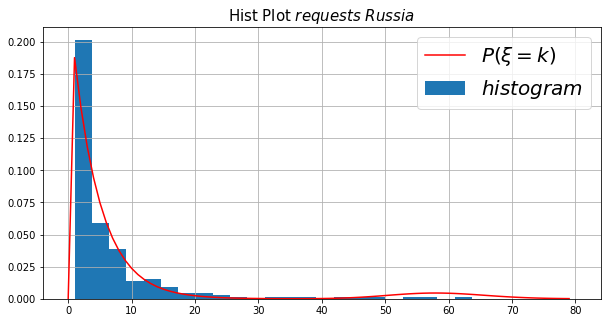

In [960]:
delimiter = 30
missed_vals = 2

sample1, sample2 = process_sample(requests, delimiter, missed_vals)
a1 = np.average(sample1)
a2 = np.average(sample2)
param1 = GMM_geom(sample1)

param2 = GMM_Poisson(sample2)

P1 = geom_param(param1)
P2 = Poisson_param(param2)
param3 = GMM_mix_distrib(requests, a1, a2)
print("parameters p, a1, a2 = ", np.around([param3[0], param1, param2], 3))
Mixed = mix_distrib_param(param3, P1, P2)

nrow = 1
fig, (ax1) = plt.subplots(nrows=nrow, figsize=(10,5*nrow))
plot_hist(requests, 80, Mixed, ax1, "$requests$ $Russia$", 30)

alfa = 0.05
r = 15
Chi_2_crit(requests, r, Mixed, alfa, 3)


In [981]:
def shift_exp_param(param):
    h, sigm = param
    def shift_exp(t):
        if t <= h:
            return 0
        else:
            return 1/sigm * np.exp((h - t) / sigm)
    def F(t):
        if t <= h:
            return 0
        else:
            return 1 - np.exp((h - t) / sigm)
    return shift_exp, F

from scipy.optimize import fsolve

def GMM_shift_exp(sample, missed_vals):
    tmp = np.sort(time_arr1)[0:len(time_arr1)-missed_vals]
    a1 = np.average(tmp)
    a2 = np.std(tmp)
    return [ a1 - a2, a2]

def divide_time1(time, r, func):
    tmp1 = np.bincount(time)
    interv = len(time)//r
    intervp = 1/r
    m = np.zeros(r)
    p = np.zeros(r + 1)
    bounds = np.zeros(r + 1)
    j = 0
    h = 0.25
    interval_sum = 0
    for i in range(1, r + 1):
        while (p[i] < intervp) and (func(interval_sum) < func(max(time))):
            interval_sum +=h
            p[i] = func(interval_sum) - func(bounds[i - 1])   
        bounds[i] = interval_sum
        tmp = time[time < bounds[i]]
        m[i - 1] = len(tmp[tmp >= bounds[i - 1]])
    p[r] = 1 -sum(p[:r])
    p = p[1:]
    return m, p

def Chi_2_crit1(sample, r, P, alfa, num_param):
    m, p = divide_time1(sample, r, P)
    
    chi_stat = Chi_squre_number(m, p)
    chi_2 = chi2(r - 1 - num_param)
    print("Chi2 degree: ", r - 1 - num_param)
    chi_2_tres1 = chi_2.ppf(1 - alfa)
    print("Chi2 statistic:         ", round(chi_stat, 2))
    print("Chi2 treshold val right:", round(chi_2_tres1, 2))

parameters h, sigma =  [11, 25.600613184084786]
Chi2 degree:  9
Chi2 statistic:          0.09
Chi2 treshold val right: 16.92


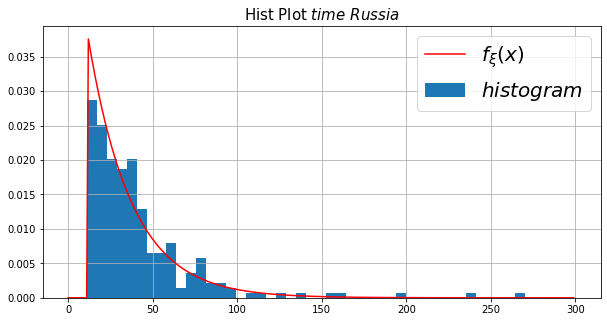

In [986]:
missed_vals = 2
param = GMM_shift_exp(time_arr, missed_vals)
P , F = shift_exp_param([min(time_arr), param[1]])
print("parameters h, sigma = ", [min(time_arr), param[1]])

nrow = 1
fig, (ax1) = plt.subplots(nrows=nrow, figsize=(10,5*nrow))
plot_hist(time_arr, 300, P, ax1, "$time$ $Russia$", 50)

alfa = 0.05
r = 12
Chi_2_crit1(time_arr, r, F, alfa, 2)


In [919]:
df_usa = data[(data["country_txt"] == "United States")] 
print("Data for USA shape: " , df_usa.shape)

Data for USA shape:  (2836, 5)


In [920]:
df_usa = compute_and_add_days(df_usa, "days from start")
print("Preprocess data for USA, with days from start, shape: " , df_usa.shape)
df_usa.head()

Preprocess data for USA, with days from start, shape:  (2803, 6)


,iyear,imonth,iday,country,country_txt,days from start
0,1970,1,1,217,United States,0
1,1970,1,1,217,United States,0
2,1970,1,2,217,United States,1
3,1970,1,2,217,United States,1
4,1970,1,3,217,United States,2


In [924]:
step = 10;
time_proc1 = (df_usa.iloc[:,5:].values).reshape(2803)
time_proc1 = np.diff(time_proc1)
print(time_proc1)
time_arr1, requests1 = make_reduce(df_usa, first_method_reduce, step, "USA")

[ 0  1  0 ...  4 11  0]
Reduce data for USA with days from start, shape:  465
time intervals = 
[587  81  66  42  24  18  20  21  36  47  17  28  26  15  47  38  22  18
  28  14  56  15  11  17  40  22  30  38  64  27  11  14  11  12  33  68
  39  28  28  36 225  53  83 119  68  20  33  20  24  48  38  33  16  30
  83  74  69  30  49  42  70  28  29  49  19  21  24  42  13  73  23  16
  45  75  37  21  24  15  82  41  24  30  31  17  46  37  23  50  20  15
  48  51  27  35  40  22  21  79  11  44  28  33  32  11  26  18  40  38
  30  19  18  14  25  56  33  35  34  19  14  41  22  46  30  52  42  13
  21  27  35  23  16  20  45  19  56  19  37  14  32  24  26  30  30  18
  11  20  35  30  21  28  66  63  42  14  15  27  24  35  26  14  13  21
  69  30  24  55  15  24  14  49  31  18  21  33  18  38  27  50  45  23
  25  18  14  45  34  16  61  35  26  90  25  14  11  36  17  40  38  24
  27  18  23  36  23  17  32  31  17  19  19  62  67  13  21  29  16  14
  22  35  19  35  34  72  34

In [925]:
alfa = 0.05
print("Wallis-Mur criterion")
Wallis_Murr_crit(time_proc1, alfa, "Time initial for USA")
Wallis_Murr_crit(time_arr1, alfa, "Time diffs for USA")
Wallis_Murr_crit(requests1, alfa, "Requests for USA")

Wallis-Mur criterion
Time initial for USA is dependet 10.11  >  1.96
Time diffs for USA is dependet 3.31  >  1.96
Requests for USA is dependet 5.25  >  1.96


parameters p, a1, a2 =  [  0.959   0.248 135.286]
Chi2 degree:  11
Chi2 statistic:          1.27
Chi2 treshold val right: 19.68


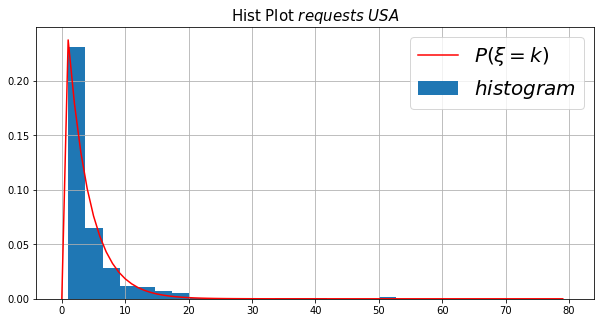

In [974]:
delimiter = 30
missed_vals = 0

sample1, sample2 = process_sample(requests1, delimiter, missed_vals)
a1 = np.average(sample1)
a2 = np.average(sample2)
param1 = GMM_geom(sample1)

param2 = GMM_Poisson(sample2)

P1 = geom_param(param1)
P2 = Poisson_param(param2)
param3 = GMM_mix_distrib(requests, a1, a2)
print("parameters p, a1, a2 = ", np.around([param3[0], param1, param2], 3))
Mixed = mix_distrib_param(param3[0], P1, P2)

nrow = 1
fig, (ax1) = plt.subplots(nrows=nrow, figsize=(10,5*nrow))
plot_hist(requests1, 80, Mixed, ax1, "$requests$ $USA$", 30)

alfa = 0.05
r = 15
Chi_2_crit(requests1, r, Mixed, alfa, 3)


parameters h, sigma =  [11, 25.600613184084786]
Chi2 degree:  9
Chi2 statistic:          0.07
Chi2 treshold val right: 16.92


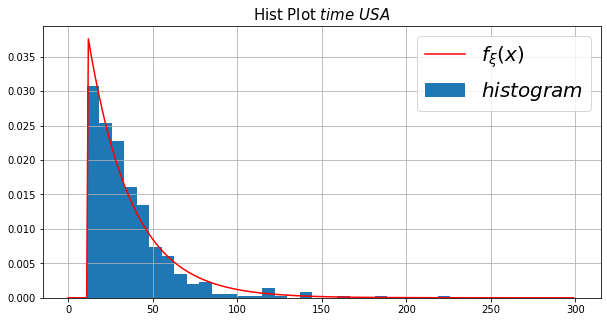

In [991]:
missed_vals = 2
param = GMM_shift_exp(time_arr1, missed_vals)
P , F = shift_exp_param([min(time_arr1), param[1]])
print("parameters h, sigma = ", [min(time_arr1), param[1]])

nrow = 1
fig, (ax1) = plt.subplots(nrows=nrow, figsize=(10,5*nrow))
plot_hist(time_arr1, 300, P, ax1, "$time$ $USA$", 40)

alfa = 0.05
r = 12
Chi_2_crit1(time_arr1, r, F, alfa, 2)